# Sterren binnen 10 parsec van de zon

Anthony G.A. Brown<br/>
Sterrewacht Leiden, Universiteit Leiden<br/>
<brown@strw.leidenuniv.nl>

We gaan nu de gegevens opvragen van alle sterren in de Gaia DR2 catalogus die zich op een afstand van 10 parsec of minder van de zon bevinden. Dit betekent dat hun parallax groter dan 100 mas moet zijn. 

## ADQL query

We gebruiken de volgende ADQL query:

```
 1 select source_id, ra, dec, parallax, pmra, pmdec, radial_velocity, phot_g_mean_mag, bp_rp
 2 from gaiadr2.gaia_source
 3 where 
 4 parallax >= 100
 5 and
 6 bp_rp is not null
 7 and
 8 (astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*exp(-0.4*(phot_g_mean_mag-19.5))
 9 or
10 astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1)
11 and
12 1.0+0.015*(bp_rp*bp_rp)<phot_bp_rp_excess_factor
13 and
14 1.3+0.06*(bp_rp*bp_rp)>phot_bp_rp_excess_factor
```

Dit ziet er wat ingewikkelder uit dan verwacht (we hoeven ten slotte alleen te selecteren op $\varpi>100$ mas). De query kan in de volgende stappen onderverdeeld worden:
* Regels 1 en 2 bevatten de instructie om uit het Gaia Archive de astrometrie en radi&euml;le snelheidsgegevens te halen. Er wordt ook gevraagd naar de schijnbare helderheid van de ster (`phot_g_mean_mag`) en de kleur (`bp_rp`) (daarover meer verderop in dit notebook).
* Regels 3 en 4 bevatten de voorwaarde dat de parallax groter dan 100 milli-boogseconden moet zijn
* De rest van de regels bevatten voorwaarden die ervoor zorgen dat we alleen betrouwbare gegevens uit de catalogus halen. Hiermee worden vooral sterren met foutieve parallax metingen weggefilterd.

Omdat we nu de gegevens van meerdere sterren opvragen en we wellicht meerdere analyses will doen met dezelfde gegevens is het handig om deze als tabel op onze eigen harde schijf op te slaan. Voer de query uit in het web interface van het Gaia Archive (geef hierbij de query een naam, bijvoorbeeld "TienParsecSample", zoals in het plaatje te zien net boven de query)

<img src="./figuren/tenparsec-query.png" />

en klik vervolgens op het in het plaatje hierboven omcirkelde _download_ icoontje om de tabel te downloaden. De tabel wordt dan opgeslagen als `TienParsecSample-result.vot`. De tabel is voor de NWD workshop al klaargezet in de `data` folder (als `TienParsecSample.vot`) om zeker te zijn dat de gegevens beschikbaar zijn.

Standaard worden de tabellen opgeslagen in het zogenaamde Virtual Observatory Table (VOT) formaat, maar je kan andere data formaten voor de tabel kiezen met behulp van de boven omcirkelde keuzelijst (onderin plaatje). Bijvoorbeeld het CSV formaat is handig voor inlezen in Excel.

### ADQL Query in Python

De onderstaande code laat zien hoe de query in Python uitgevoerd kan worden

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from astroquery.gaia import Gaia

from astropy.table import Table
import astropy.units as u
Av = (u.AU/u.yr).to(u.km/u.s)

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [2]:
querystring = """select source_id, ra, dec, parallax, pmra, pmdec, radial_velocity, phot_g_mean_mag, bp_rp 
from gaiadr2.gaia_source 
where 
parallax >= 100 
and 
bp_rp is not null
and 
(astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*exp(-0.4*(phot_g_mean_mag-19.5))
or 
astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1)
and 
1.0+0.015*(bp_rp*bp_rp)<phot_bp_rp_excess_factor 
and 
1.3+0.06*(bp_rp*bp_rp)>phot_bp_rp_excess_factor"""

jobtenpc = Gaia.launch_job_async(querystring, name="TienParsecSample", dump_to_file=False)

tienparsec_data = jobtenpc.get_results()

Query finished.


In [3]:
tienparsec_data[0:10].show_in_notebook()

idx,source_id,ra,dec,parallax,pmra,pmdec,radial_velocity,phot_g_mean_mag,bp_rp
,,deg,deg,mas,mas / yr,mas / yr,km / s,mag,mag
0,102162639019033600,38.405129306924245,24.92422567738258,100.28345181005093,48.81816801615412,-676.1670258498333,--,11.539992,2.976964
1,527956488339113600,8.142228910872236,67.2333130462461,100.40536402450441,1703.438833564281,-250.7825586275544,--,11.099288,2.6245546
2,3243715604392800512,57.6826095476262,-6.100800626721694,100.55992417936527,-445.44486989420284,-1371.116808962438,--,11.456071,2.8190699
3,478823780455331968,71.22644569109687,63.40278516084304,100.5826048410471,6.475130325584246,116.17820881231174,--,18.254353,1.699482
4,6109610086872510592,210.96255277258084,-42.6993066973693,100.61485253632038,-379.48390198946834,-290.22665274543465,--,11.707547,2.9204645
5,1187851653287128576,223.62306823918445,16.10054736482377,100.681067272193,279.33968902580807,-117.95892458939065,-7.999864477807584,9.125617,2.291028
6,4535928365908541440,280.29319733184315,24.789026782880168,100.68301086475806,498.7568143476454,57.35021653455112,--,12.957436,3.5720034
7,4535928365908540416,280.2930563710574,24.78771629927903,100.72340027254124,505.3049253337912,87.05634609898787,--,10.722715,3.1077967
8,272855565762295680,69.42271403538027,52.89156892007314,100.7796606034136,303.95997780902775,-475.03235678142244,33.74757780312413,7.949504,1.8050041


Via de Python query kan de data ook op de lokale schijf opgeslagen worden door de regel `jobtenpc = ...` te vervangen door

```
jobtenpc = Gaia.launch_job_async(querystring, name="TienParsecSample", dump_to_file=True, \
                                 output_file="TienParsecSample.csv", output_format='csv')
```
waarbij hier gekozen is voor een tabel in CSV formaat.

## Visualisatie van de sterren binnen 10 parsec van de zon

De onderstaande code maakt gebruik van de opgeslagen tabel `TienParsecSample.vot` (in de `data` folder) en laat zien hoe je een plaatje van de 3D verdeling van de buursterren van de zon kunt maken met [matplotlib](https://matplotlib.org/).

Eerste lezen we de tabel met behulp van een toepassing (`Table`) uit het [Astropy](http://www.astropy.org/) pakket.

In [4]:
tienparsec_data = Table.read('./data/TienParsecSample.vot', format='votable')
tienparsec_data[0:10].show_in_notebook()

idx,source_id,ra,dec,parallax,pmra,pmdec,radial_velocity,phot_g_mean_mag,bp_rp
,,deg,deg,mas,mas.yr**-1,mas.yr**-1,km.s**-1,mag,mag
0,102162639019033600,38.405129306924245,24.92422567738258,100.28345181005093,48.81816801615412,-676.1670258498333,--,11.539992,2.976964
1,527956488339113600,8.142228910872236,67.2333130462461,100.40536402450441,1703.438833564281,-250.7825586275544,--,11.099288,2.6245546
2,3243715604392800512,57.6826095476262,-6.100800626721694,100.55992417936527,-445.44486989420284,-1371.116808962438,--,11.456071,2.8190699
3,478823780455331968,71.22644569109687,63.40278516084304,100.5826048410471,6.475130325584246,116.17820881231174,--,18.254353,1.699482
4,6109610086872510592,210.96255277258084,-42.6993066973693,100.61485253632038,-379.48390198946834,-290.22665274543465,--,11.707547,2.9204645
5,1187851653287128576,223.62306823918445,16.10054736482377,100.681067272193,279.33968902580807,-117.95892458939065,-7.999864477807584,9.125617,2.291028
6,4535928365908541440,280.29319733184315,24.789026782880168,100.68301086475806,498.7568143476454,57.35021653455112,--,12.957436,3.5720034
7,4535928365908540416,280.2930563710574,24.78771629927903,100.72340027254124,505.3049253337912,87.05634609898787,--,10.722715,3.1077967
8,272855565762295680,69.42271403538027,52.89156892007314,100.7796606034136,303.95997780902775,-475.03235678142244,33.74757780312413,7.949504,1.8050041


Het volgende blok code laat zien hoe je de 3D posities van de 247 sterren in de tabel berekent. In Python kan dit zonder een "loop" constructie omdat berekeningen op hele kolommen in een tabel toegepast kunnen worden.

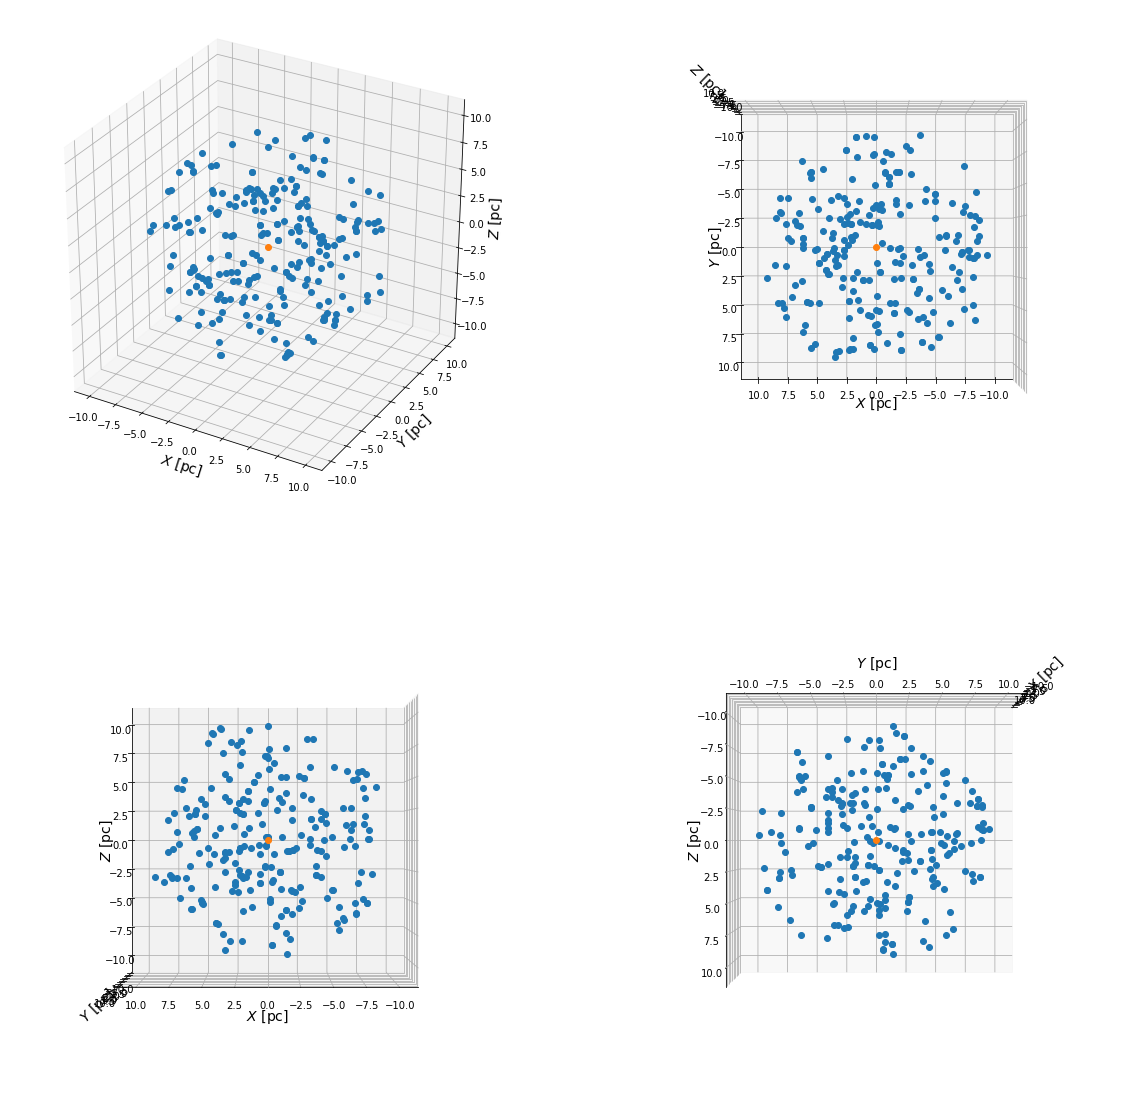

In [5]:
ra = tienparsec_data['ra']*np.pi/180
dec = tienparsec_data['dec']*np.pi/180
parallax = tienparsec_data['parallax']

r = [np.cos(dec)*np.cos(ra), np.cos(dec)*np.sin(ra), np.sin(dec)]

x = r[0]*1000/parallax
y = r[1]*1000/parallax
z = r[2]*1000/parallax

fig = plt.figure(figsize=(20,20))
axposA = fig.add_subplot(2, 2, 1, projection='3d')
axposA.view_init(None, None)
axposB = fig.add_subplot(2, 2, 2, projection='3d')
axposB.view_init(90, 90)
axposC = fig.add_subplot(2, 2, 3, projection='3d')
axposC.view_init(0, 90)
axposD = fig.add_subplot(2, 2, 4, projection='3d')
axposD.view_init(180, 0)

for axpos in [axposA, axposB, axposC, axposD]:
    axpos.plot(x, y, z, 'o')
    axpos.set_xlim(-11,11)
    axpos.set_ylim(-11,11)
    axpos.set_zlim(-11,11)
    axpos.set_xlabel(r'$X$ [pc]', fontsize=14)
    axpos.set_ylabel(r'$Y$ [pc]', fontsize=14)
    axpos.set_zlabel(r'$Z$ [pc]', fontsize=14)
    #axpos.plot([0,0], [0,0], [-15,15], 'k:')
    #axpos.plot([-15,15], [0,0], [0,0], 'k:')
    #axpos.plot([0,0], [-15,15], [0,0], 'k:')
    axpos.plot([0], [0], [0], 'o')

plt.show()

## Helderheid en kleur van de sterren

Gaia meet niet alleen de astrometrie en radi&euml;le snelheid van sterren maar ook allerlei andere gegevens waaronder de schijnbare helderheid en de "kleur" van de sterren. De schijnbare helderheid is een maat voor hoe helder de ster voor ons lijkt, een bepaalde ster kan dus schijnbaar helder zijn omdat die dichtbij staat of omdat die intrinsiek helder is. Gaia meet de hoeveelheid licht die het van de sterren onvangt als de flux $F$ (in Watt per eenheid van oppervlak) over een bepaald golflengtebereik. De helderheid van sterren wordt over het algemeen aangegeven met een logarithmische schaal, de _magnitude schaal_. In formule vorm wordt de schijnbare magnitude $m$ van een ster gegeven door:

\begin{equation}
    m = -2.5\log_{10}F + C\,,
\end{equation}

waarbij $C$ een normalisatie constante is. De magnitude schaal zorgt ervoor dat het enorme verschil in (schijnbare) helderheid tussen verschillende soorten sterren op een overzichtelijke manier weergegeven kan worden. Voor twee sterren met schijnbare helderheid $F_1$ en $F_2$ geldt:

\begin{equation}
    m_1 - m_2 = -2.5(\log_{10}F_1 - \log_{10}F_2) = -2.5\log_{10}\left(\frac{F_1}{F_2}\right)\,.
\end{equation}

Het verschil in schijnbare magnitude zegt dus iets over de verhouding van de hoeveelheid energie de we ontvangen van ster 1 ten opzichte van ster 2. Een magnitude verschil van 5 komt overeen met een factor 100 in flux. Uit de formules boven volgt ook dat sterren die schijnbaar _helderder_ zijn een _lagere waarde_ van $m$ hebben.

De fluxen van sterren kunnen worden bepaald in verschillende golflengte banden. Bijvoorbeeld Gaia meet de flux van sterren in een hele breder band, $G$ genaamd, die het hele optische spectrum omvat, en ook in twee iets minder brede banden BP en RP die de blauwe en rode helft van het optisch bereik beslaan. De drie corresponderende magnitudes zijn dan:

\begin{equation}
    G = -2.5\log_{10}F_G + C_G\,, \quad G_\mathrm{BP} = -2.5\log_{10}F_\mathrm{BP}+C_\mathrm{BP}\,, 
    \quad G_\mathrm{RP} = -2.5\log_{10}F_\mathrm{RP}+C_\mathrm{RP}\,.
\end{equation}

Het verschil tussen magnituden gemeten over verschillende golflengte banden wordt de "kleur" van de ster genoemd. Bijvoorbeeld:

\begin{equation}
    G_\mathrm{BP} - G_\mathrm{RP} = 2.5\log_{10}\left(\frac{F_\mathrm{RP}}{F_\mathrm{BP}}\right) + C_\mathrm{BP}-C_\mathrm{RP}\,.
\end{equation}

In dit geval geldt dat als de waarde van de kleur $G_\mathrm{BP} - G_\mathrm{RP}$ groot (positief) is de ster naar verhouding meer licht in het rood dan in het blauw uistraalt, we spreken dan van een "rode" ster. "Blauwe" sterren hebben juist kleine (negatieve) waarden van $G_\mathrm{BP} - G_\mathrm{RP}$. De kleur van een ster vertelt ons iets over de eigenschappen van de ster, bijvoorbeeld over de oppervlakte temperatuur. Sterren met een hoge temperatuur ($10\,000$ Kelvin of meer) zijn blauw van kleur en sterren met een lage temperatuur (paar duizend Kelvin) zijn rood van kleur. 

De kleur van een ster is onafhankelijk van de afstand waarop die ster staat omdat we naar de verhouding van de fluxen kijken. De schijnbare helderheid van een ster hangt echter wel af van de afstand. Als we twee sterren nemen die intrinsiek evenveel licht uitstralen en we zetten de een 10 keer zover weg van de zon als de ander, zal de verderweg staande ster $10^2=100$ keer zwakker lijken (dus een 5 magnituden grotere schijnbare helderheid hebben) omdat het uitgezonden licht over een 100 keer groter oppervlak verspreid wordt. Om sterren wat betreft hun onderlinge helderheid te vergelijken moeten we dus hun afstand weten. Als we de afstand $b$ kennen kunnen we de intrinsieke helderheid uitrekenen. De afspraak is dat de instrinsieke helderheid van een ster de schijnbare helderheid is die de ster zou hebben als die op een afstand van 10 pc zou staan. Dit intrinsieke helderheid wordt aangegeven met de absolute magnitude $M$

\begin{equation}
    M = m - 5\log_{10}b + 5\,,
\end{equation}

waarbij $b$ in parsec gegeven is. Het is een oefening voor de lezer om aan te tonen dat deze formule klopt. Als we de parallax gebruiken in milli-boogseconde in plaats van de afstand in parsec krijgen we:

\begin{equation}
    M = m + 5\log_{10}\varpi - 10\,.
\end{equation}

In de onderstaande code zetten we de helderheid van de sterren binnen 10 pc van de zon uit tegen hun kleur met behulp van de magnituden die in de tabel staan ($G$ is `phot_g_mean_mag` en $G_\mathrm{BP} - G_\mathrm{RP}$ is `bp_rp`). Het plaatje links laat langs de verticale as de schijnbare magnitude zien en het plaatje rechts de absolute magnitude.

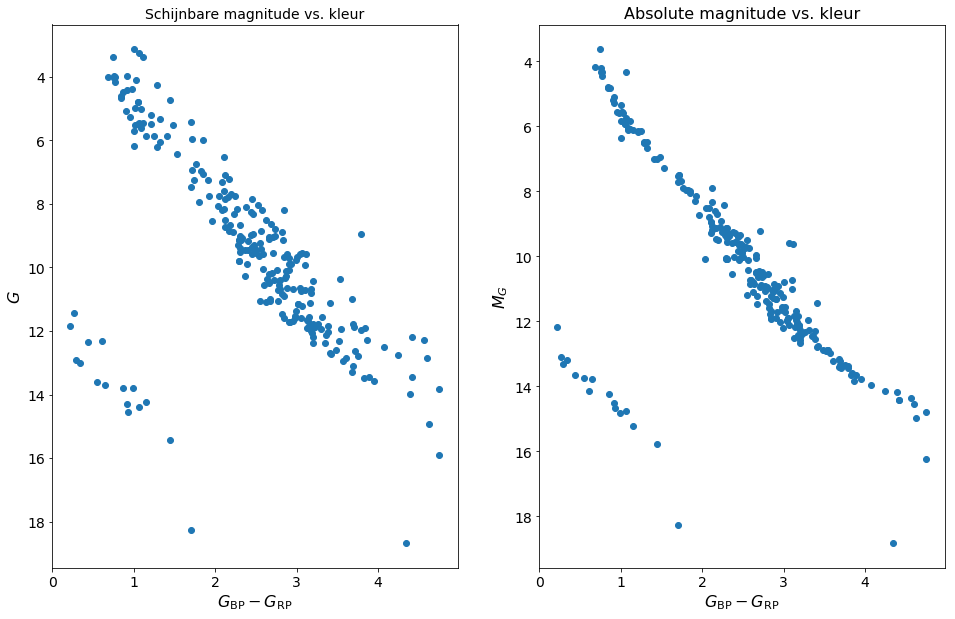

In [6]:
gmag = tienparsec_data['phot_g_mean_mag']
bpminrp = tienparsec_data['bp_rp']

figcmd = plt.figure(figsize=(16,10))
axA = figcmd.add_subplot(1,2,1)
axB = figcmd.add_subplot(1,2,2)

axA.plot(bpminrp, gmag, 'o')
axA.invert_yaxis()
axA.set_xlabel('$G_\mathrm{BP}-G_\mathrm{RP}$', fontsize=16)
axA.set_ylabel('$G$', fontsize=16)
axA.tick_params(axis="x", labelsize=14)
axA.tick_params(axis="y", labelsize=14)
axA.set_title('Schijnbare magnitude vs. kleur', fontsize=14)

axB.plot(bpminrp, gmag+5*np.log10(parallax)-10, 'o')
axB.invert_yaxis()
axB.set_xlabel('$G_\mathrm{BP}-G_\mathrm{RP}$', fontsize=16)
axB.set_ylabel('$M_G$', fontsize=16)
axB.tick_params(axis="x", labelsize=14)
axB.tick_params(axis="y", labelsize=14)
axB.set_title('Absolute magnitude vs. kleur', fontsize=16)

plt.show()

In deze diagrammen is de verticale as omgekeerd zodat heldere sterren bovenaan staan en zwakke onderaan. In het plaatje links zie je sterren met dezelfde kleur die verschillende schijnbare magnituden hebben. In het plaatje rechts is de afstand in rekening gebracht en dan blijkt dat sterren met dezelfde kleur ook dezelfde absolute magnitude ofwel intrinsieke helderheid hebben. We zien in beide plaatjes twee reeksen sterren, waarvoor er een strikt verband is tussen intrinsieke helderheid en kleur. De reeks met de meeste sterren erin wordt de "hoofdreeks" genoemd. Het verband tussen kleur en helderheid kan deels verklaard worden door sterren te beschouwen als objecten die stralen als een zwart lichaam. In dat geval is de totale hoeveelheid uitgestraalde licht evenredig met de temperatuur van de ster tot de vierde macht en met het oppervlak van de ster (dus straal in het kwadraat). De temperatuur bepaalt dan weer de kleur.

De reeks sterren links onderin bevat de zogenaamde "witte dwergen". Dit zijn sterren met een blauwe kleur (lage waarde van $G_\mathrm{BP}-G_\mathrm{RP}$) en ze zijn erg lichtzwak omdat ze heel klein zijn (ongeveer zo groot als de aarde, de zon is 100 keer groter in diameter).

Deze kleur-magnitude diagrammen bevatten dus heel veel informatie over de natuurkunde van sterren en spelen dus ook een centrale rol in ons begrip van sterren. Een van de belangrijkste toepassingen van Gaia is dan ook om voor zoveel mogelijk en zoveel mogelijk soorten sterren afstanden te verzamelen zodat we met behulp van de absolute magnitude en kleur onze natuurkundige modellen van sterren kunnen testen en verder ontwikkelen.